In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pylab as plt
np.set_printoptions(threshold=np.inf)#不使用科学计数法

In [4]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA

In [5]:
df = pd.read_csv('./airline_passengers.csv',index_col=0)

In [6]:
df

,Thousands of Passengers
Month,
Jan-49,112
Feb-49,118
Mar-49,132
Apr-49,129
May-49,121
...,...
Aug-60,606
Sep-60,508
Oct-60,461


In [7]:
dates = pd.date_range('1949-01-01','1960-12-01',freq='MS')

In [8]:
dates

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', length=144, freq='MS')

In [9]:
df['Date'] = dates

In [10]:
df.set_index('Date', inplace=True)

In [11]:
df

,Thousands of Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [12]:
ts=df.iloc[:,0]

In [13]:
ts

Date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: Thousands of Passengers, Length: 144, dtype: int64

In [41]:
def arima_for(ts,p,i,q):
    train=ts[:int(-0.2*len(ts))]
    test=ts[int(-0.2*len(ts)):]
    model = ARIMA(train, order=(p,i,q)) 
    result_arima = model.fit(disp=-1)
    fc, se, conf = result_arima.forecast(int(0.2*len(ts)), alpha=0.05)
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [15]:
import pmdarima as pm
from pmdarima import auto_arima

In [38]:
def arima_for_new(ts,p,i,q):#用auto_arima
    train=ts[:int(-0.2*len(ts))]
    test=ts[int(-0.2*len(ts))-1:]
    model = auto_arima(train, order=(p, i, q)) 
    result_arima = model.fit(train)
    forecast = model.predict(n_periods=len(test))
    forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(forecast, label='forecast')
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [17]:
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

# Importing everything from forecasting quality metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [18]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):#acf_pacf检验
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [19]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):#稳定性检验
    '''
    Pass in a time series and an optional title, function returns an ADF report
    '''
    print(f'Augmented Dickey-fuller test: {title}')
    result = adfuller(series.dropna(), autolag='AIC') # dropna() handles differenced data
    
    labels = ['adf test stats','p-value', '# of lags', '# of observations']
    out = pd.Series(result[0:4], index=labels)
    
    for key,val in result[4].items():
        out[f'critical value ({key})'] = val
    
    print(out.to_string())
    
    if result[1] <= 0.05:
        print("Null Hypothesis rejected! Time series is stationary!")
    else:
        print("Failed to reject Null Hypothesis! Time Series is not stationary!")

In [20]:
adf_test(ts)

Augmented Dickey-fuller test: 
adf test stats            0.815369
p-value                   0.991880
# of lags                13.000000
# of observations       130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Failed to reject Null Hypothesis! Time Series is not stationary!


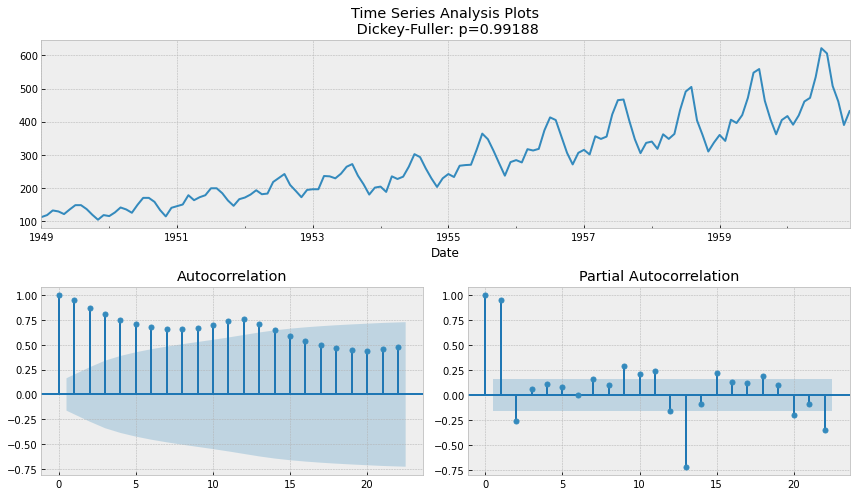

In [21]:
tsplot(ts)

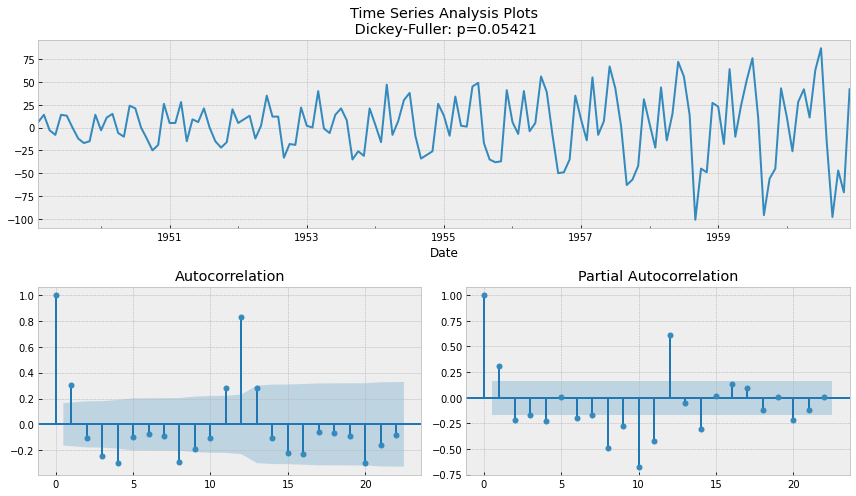

In [22]:
ts_dif= ts - ts.shift(1)#差分
tsplot(ts_dif[1:])

In [23]:
adf_test(ts_dif)

Augmented Dickey-fuller test: 
adf test stats           -2.829267
p-value                   0.054213
# of lags                12.000000
# of observations       130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Failed to reject Null Hypothesis! Time Series is not stationary!


使用auto arima自动定参数

In [24]:
auto_arima(ts,start_p=0,max_p=6,start_q=0,max_q=3,seasonal=False,trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1415.278, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1403.473, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1398.827, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1413.909, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1396.121, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1398.386, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1397.975, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1394.683, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1397.258, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1401.852, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1378.338, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1396.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(4, 1, 3)   Log Likelihood                -674.913
Date:                Mon, 18 Apr 2022   AIC                           1365.825
Time:                        20:39:23   BIC                           1389.528
Sample:                             0   HQIC                          1375.457
                                - 144                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5582      0.117     -4.782      0.000      -0.787      -0.329
ar.L2          0.4935      0.113      4.375      0.000       0.272       0.715
ar.L3          0.1238      0.128      0.970      0.332      -0.126       0.374
ar.L4         -0.5213      0.085     -6.136      0.000      -0.688      -0.355
ma.L1          0.9069      0.094      9.657      0.000       0.723       1.091
ma.L2         -0.5590      0.145     -3.866      0.000      -0.842      -0.276
ma.L3         -0.7385      0.109     -6.778      0.000      -0.952      -0.525
sigma2       724.1727     85.616      8.458      0.000     556.369     891.976
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                14.59
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               5.66   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS wi

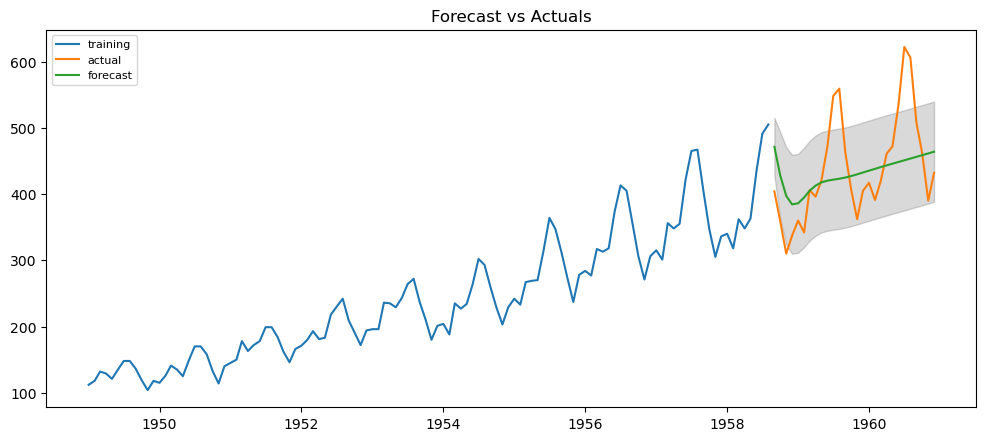

In [42]:
arima_for(ts,2,1,1)

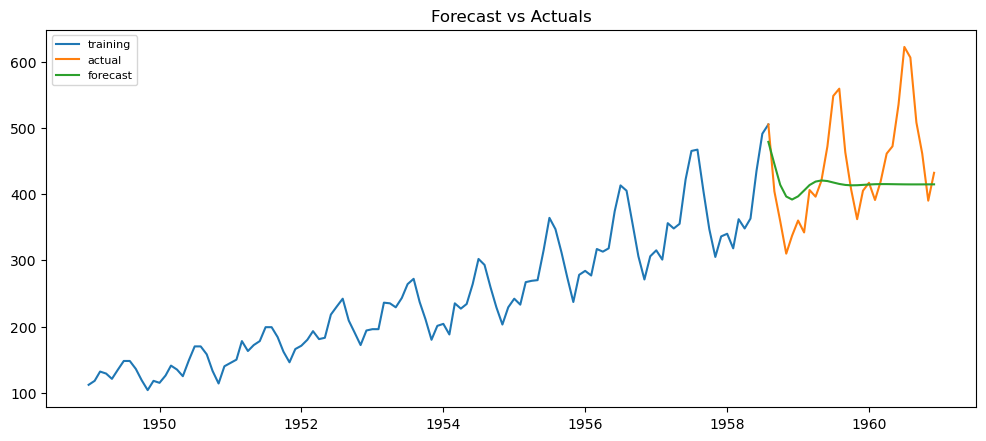

In [40]:
arima_for_new(ts,4,1,3)

加入周期性

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

In [28]:
result = seasonal_decompose(ts)

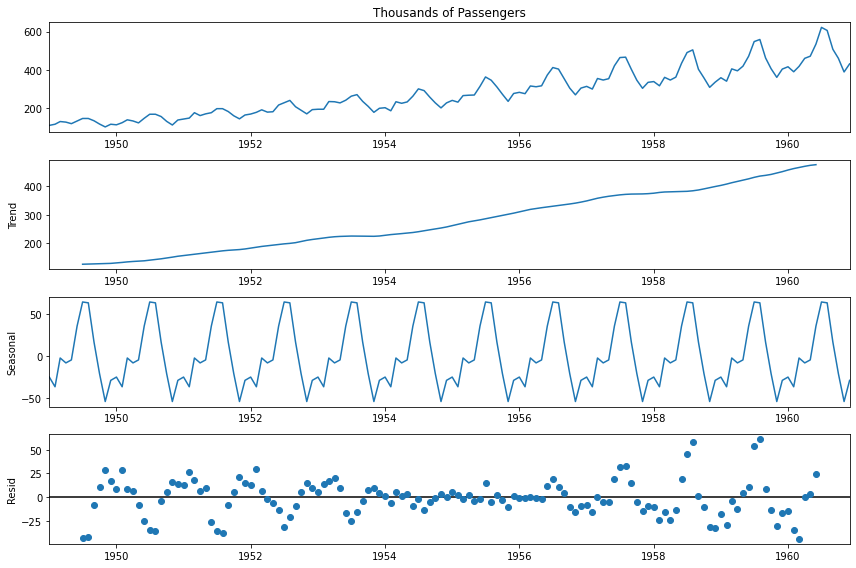

In [29]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,8
result.plot();

In [30]:
auto_arima(ts,start_p=0,max_p=6,start_q=0,max_q=3,seasonal=True,m=12,trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1032.128, Time=0.20 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.24 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.77 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.28 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.16 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.30 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.52 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.24 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.11 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=1.74 sec
 ARIMA(0,1,1)(1,1,1)[12]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Mon, 18 Apr 2022   AIC                           1019.178
Time:                                     20:39:37   BIC                           1030.679
Sample:                                          0   HQIC                          1023.851
                                             - 144                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      0.090     -1.372      0.170      -0.301       0.053
ar.S.L24       0.1911      0.107      1.783      0.075      -0.019       0.401
sigma2       130.4480     15.527      8.402      0.000     100.016     160.880
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.92   Prob(JB):                         0.10
Heteroskedasticity (H):               2.70   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
def sarimax_for(ts,p,i,q,a,b,c,m):
    train=ts[:int(-0.2*len(ts))]
    test=ts[int(-0.2*len(ts))-1:]
    model = SARIMAX(ts, order=(p,i,q), seasonal_order=(a,b,c,m),enforce_invertibility=False)
    result_sarimax = model.fit()
    #print(result_sarimax.summary())
    
    start = len(train)
    end = len(train)+ len(test) -1
    
    fc = result_sarimax.predict(start=start, end=end, typ='levels')
    #fc = result_sarimax.forecast(n_periods=len(test))
    fc_series = pd.Series(fc, index=test.index)
    #print(fc_series)
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


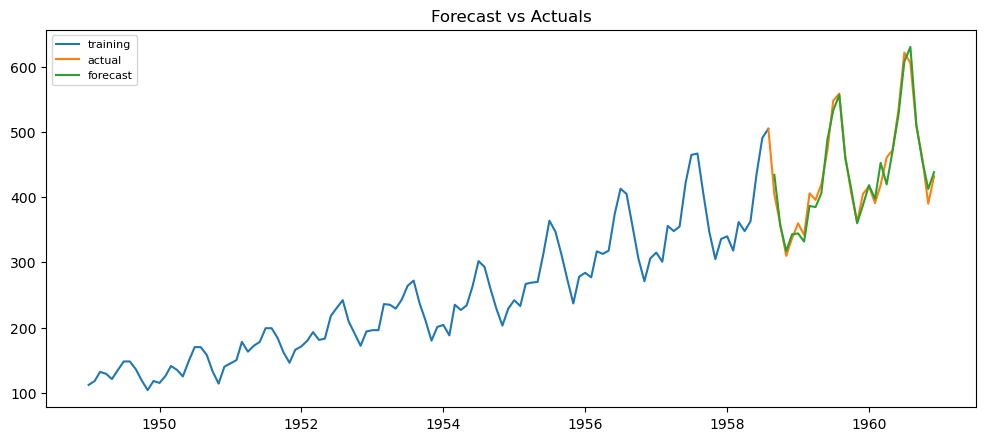

In [36]:
sarimax_for(ts,0,1,1,2,1,0,12)